In [1]:
import gc
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ShuffleSplit

from sklearn.model_selection import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV

warnings.filterwarnings('ignore')


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


基本変数定義

In [2]:
sampling_flg=0 #サンプリング有無をコントロール
submit_flg=1 #保存するかをコントロール（サンプリングしない時のみ）

SEED=12345
sample_num=10000
fold_num=5

#train関連
train_dir='../../01_input/train.csv'
train_feature_dir_1='../../02_feature/113_train_NegativeCount.csv'
train_feature_dir_2='../../02_feature/114_train_means.csv'
#train_feature_dir_3='../../02_feature/116_train_quantile.csv'
#train_feature_dir_4='../../02_feature/102_train_kmeans.csv'

train_drop_col=['ID_code', 'target']
train_label='target'

#test関連
test_dir='../../01_input/test.csv'
test_feature_dir_1='../../02_feature/113_test_NegativeCount.csv'
test_feature_dir_2='../../02_feature/114_test_means.csv'
test_feature_dir_3='../../02_feature/116_test_quantile.csv'
test_feature_dir_4='../../02_feature/102_test_kmeans.csv'

test_drop_col=['ID_code']

#結果ファイル関連　nameは自分の名前に変更する
train_preds_dir='../../03_predict_train/oka_241_LightGBM_feature_selection_train.csv'
test_preds_dir='../../04_predict_test/oka_224_LightGBM__feature_selection_submission.csv'
save_col_name='oof_xgb'

sample_submission_dir='../../01_input/sample_submission.csv'
submission_target_col_name='target'
submission_id_col_name='ID_code'

前処理

In [3]:
#ロード
train_df=pd.read_csv(train_dir)
test_df=pd.read_csv(test_dir)
train_feature_df_1=pd.read_csv(train_feature_dir_1)
test_feature_df_1=pd.read_csv(test_feature_dir_1)
train_feature_df_2=pd.read_csv(train_feature_dir_2)
test_feature_df_2=pd.read_csv(test_feature_dir_2)
#train_feature_df_3=pd.read_csv(train_feature_dir_3)
#test_feature_df_3=pd.read_csv(test_feature_dir_3)
#train_feature_df_4=pd.read_csv(train_feature_dir_4)
#test_feature_df_4=pd.read_csv(test_feature_dir_4)

#train_df=pd.concat([train_df,train_feature_df_1],axis=1)
#test_df=pd.concat([test_df,test_feature_df_1],axis=1)

col_name=['mean_8','mean_44','mean_16','mean_7']
train_df=pd.concat([train_df,train_feature_df_2[col_name]],axis=1)
test_df=pd.concat([test_df,test_feature_df_2[col_name]],axis=1)
#train_df=pd.concat([train_df,train_feature_df_3],axis=1)
#test_df=pd.concat([test_df,test_feature_df_3],axis=1)
#train_df=pd.concat([train_df,train_feature_df_4],axis=1)
#test_df=pd.concat([test_df,test_feature_df_4],axis=1)

In [4]:
train_df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_194,var_195,var_196,var_197,var_198,var_199,mean_8,mean_44,mean_16,mean_7
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914,2.01422,12.694000,3.27656,1.983547
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518,0.70737,12.484900,5.83498,4.753147
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965,-0.25479,12.577200,0.99632,1.755159
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996,1.49533,11.048400,2.68778,1.534076
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104,1.99594,13.239467,4.57000,-1.066535


In [5]:
#サンプリング
if sampling_flg ==1:
    train_df=train_df.sample(n=sample_num,random_state=SEED)
    test_df=test_df.sample(n=sample_num,random_state=SEED)

In [6]:
#x,y作成
x_train=train_df.drop(train_drop_col,axis=1)
y_train=train_df[train_label]
x_test=test_df.drop(test_drop_col,axis=1)

モデル実行

In [7]:
#model_param
param = {
    "objective" : "binary", 
    "boost":"gbdt",
    "metric":"auc",
    "boost_from_average":"false",
    "num_threads":28,
    "learning_rate" : 0.01,
    "num_leaves" : 13,
    "max_depth":-1,
    "tree_learner" : "serial",
    "feature_fraction" : 0.05,
    "bagging_freq" : 5,
    "bagging_fraction" : 0.4,
    "min_data_in_leaf" : 80,
    "min_sum_hessian_in_leaf" : 10.0,
    "verbosity" : 1,
    'seed': 44000,
    }

In [8]:
folds = StratifiedKFold(n_splits=fold_num, shuffle=True, random_state=SEED)
oof_preds = np.zeros((len(x_train), 1))
test_preds = np.zeros((len(x_test), 1))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(x_train.values, y_train.values)):
    print("\n")
    print("Fold {}".format(fold_))
    trn_x,trn_y = x_train.iloc[trn_idx], y_train.iloc[trn_idx]
    val_x,val_y = x_train.iloc[val_idx], y_train.iloc[val_idx]
    trn_data = lgb.Dataset(trn_x,trn_y)
    val_data = lgb.Dataset(val_x,val_y)
    
    num_round = 1000000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 3000)
    val_pred = clf.predict(val_x, num_iteration=clf.best_iteration)
    test_pred = clf.predict(x_test, num_iteration=clf.best_iteration)
    
    print("AUC = {}".format(roc_auc_score(val_y, val_pred)))
    #print("val = {}".format(val_pred)
    oof_preds[val_idx, :] = val_pred.reshape((-1, 1))
    test_preds += test_pred.reshape((-1, 1))
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = x_train.columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    
test_preds /= fold_num
roc_score = roc_auc_score(y_train, oof_preds.ravel())
print("Overall AUC = {}".format(roc_score))



Fold 0
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.900329	valid_1's auc: 0.882935
[2000]	training's auc: 0.912304	valid_1's auc: 0.890225
[3000]	training's auc: 0.9206	valid_1's auc: 0.894422
[4000]	training's auc: 0.926997	valid_1's auc: 0.896609
[5000]	training's auc: 0.932384	valid_1's auc: 0.897666
[6000]	training's auc: 0.937116	valid_1's auc: 0.898212
[7000]	training's auc: 0.941472	valid_1's auc: 0.898681
[8000]	training's auc: 0.945415	valid_1's auc: 0.89881
[9000]	training's auc: 0.9492	valid_1's auc: 0.898883
[10000]	training's auc: 0.952829	valid_1's auc: 0.89883
[11000]	training's auc: 0.956212	valid_1's auc: 0.898767
Early stopping, best iteration is:
[8734]	training's auc: 0.948205	valid_1's auc: 0.898936
AUC = 0.8989358051188153


Fold 1
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.900958	valid_1's auc: 0.881552
[2000]	training's auc: 0.91225	valid_1's auc: 0.889197
[3000]	training

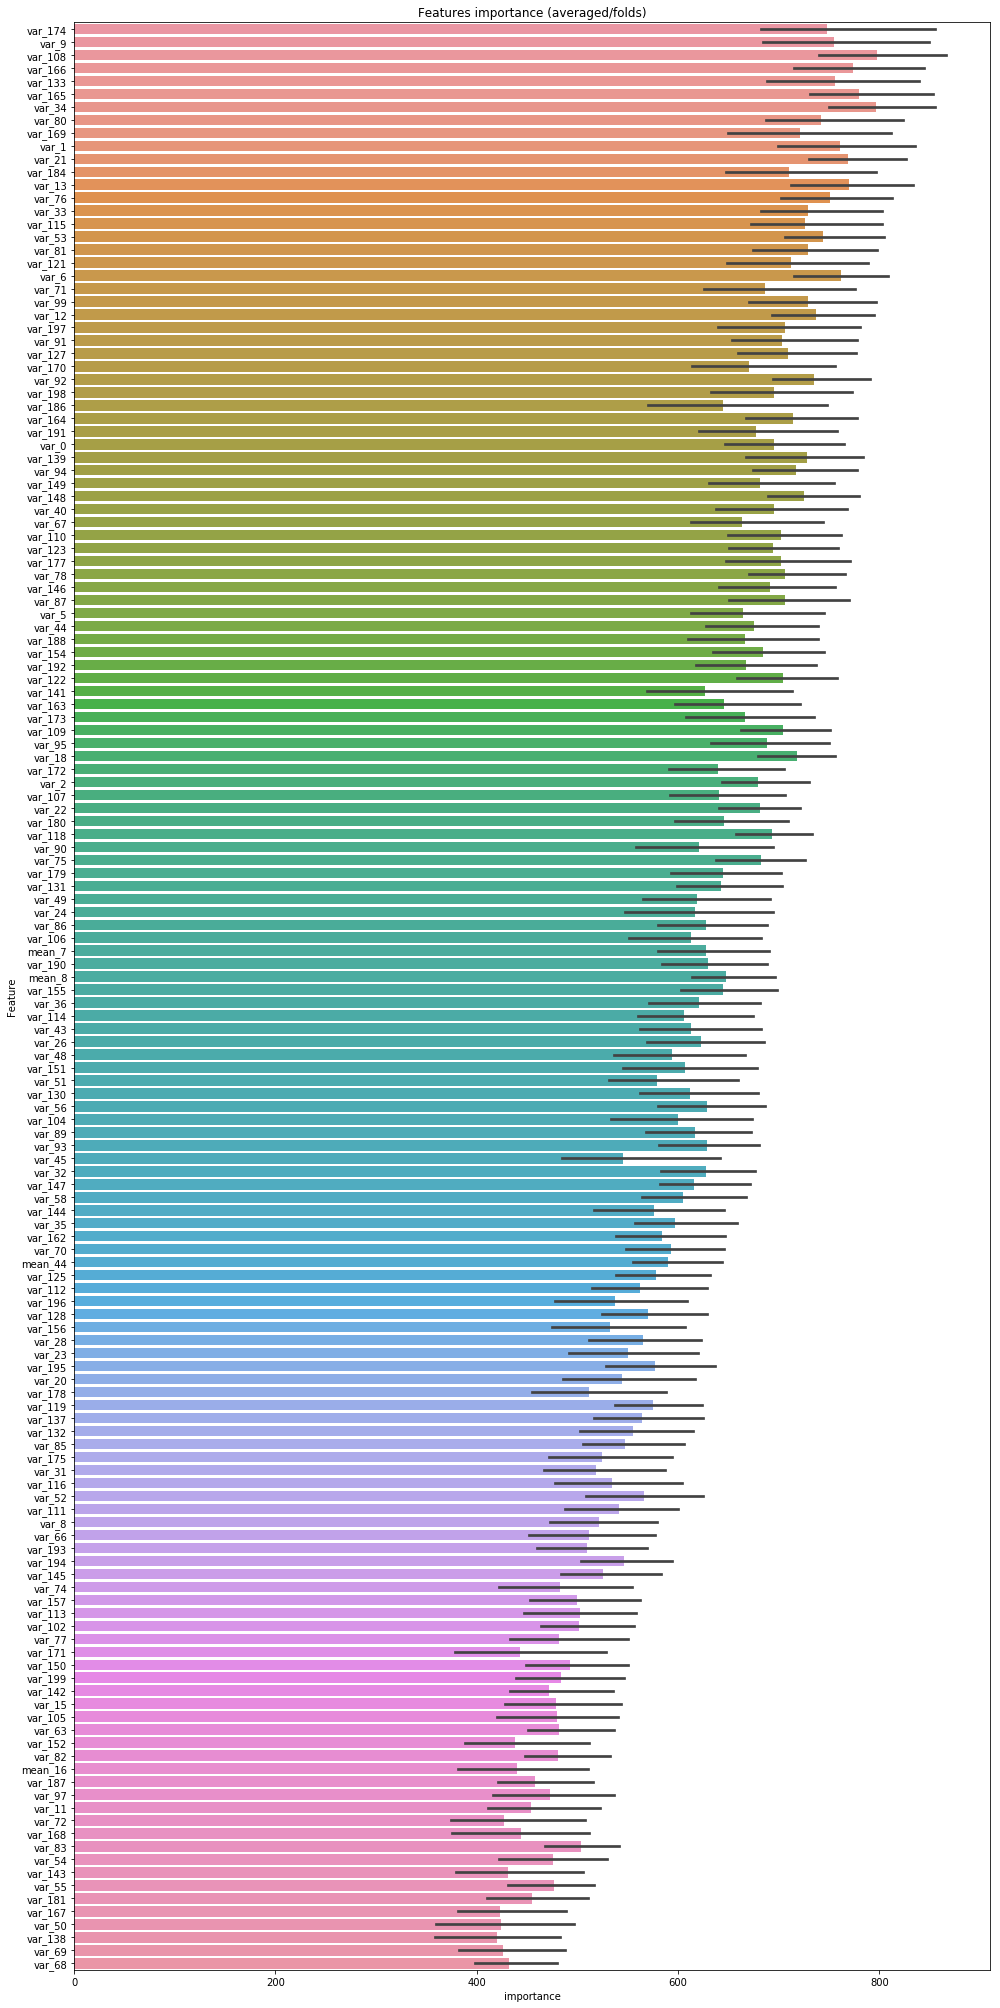

In [9]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:150].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig('../../04_predict_test/241_FI.png')

In [10]:
#結果保存
if (submit_flg ==1 and sampling_flg==0):
    series_oof_preds = pd.Series(data=oof_preds[:,0], name=save_col_name, dtype='float')
    series_oof_preds.to_csv(train_preds_dir,header=True, index=False)

    sample = pd.read_csv(sample_submission_dir)
    sample.target = test_preds[:,0].astype(float)
    sample.ID_code = test_df['ID_code']
    sample.to_csv(test_preds_dir, index=False)
    